In [1]:
import os
import io
import trimesh
import b3d
import genjax
import jax
import b3d.bayes3d as bayes3d
import jax.numpy as jnp
import numpy as np
import rerun as rr
from PIL import Image
import matplotlib.pyplot as plt
import h5py
import json
import random
from copy import deepcopy
import itertools
from tqdm import tqdm
from functools import reduce
from genjax import Pytree
from scipy.spatial.transform import Rotation
import b3d.chisight.dense.dense_model
import b3d.chisight.dense.likelihoods.laplace_likelihood
import collections

## define helper functions

In [2]:
def scale_mesh(vertices, scale_factor):
    vertices_copy = deepcopy(vertices)
    vertices_copy[:, 0] *= scale_factor[0]
    vertices_copy[:, 1] *= scale_factor[1]
    vertices_copy[:, 2] *= scale_factor[2]
    return vertices_copy

def euler_angles_to_quaternion(euler: np.ndarray) -> np.ndarray:
    """
    Convert Euler angles to a quaternion.

    Source: https://pastebin.com/riRLRvch

    :param euler: The Euler angles vector.

    :return: The quaternion representation of the Euler angles.
    """
    pitch = np.radians(euler[0] * 0.5)
    cp = np.cos(pitch)
    sp = np.sin(pitch)

    yaw = np.radians(euler[1] * 0.5)
    cy = np.cos(yaw)
    sy = np.sin(yaw)

    roll = np.radians(euler[2] * 0.5)
    cr = np.cos(roll)
    sr = np.sin(roll)

    x = sy * cp * sr + cy * sp * cr
    y = sy * cp * cr - cy * sp * sr
    z = cy * cp * sr - sy * sp * cr
    w = cy * cp * cr + sy * sp * sr
    return np.array([x, y, z, w])

def unproject_pixels(mask, depth_map, cam_matrix, fx, fy, vfov=54.43222, near_plane=0.1, far_plane=100):
    '''
    pts: [N, 2] pixel coords
    depth: [N, ] depth values
    returns: [N, 3] world coords
    '''
    depth = depth_map[mask]
    pts = np.array([[x,y] for x,y in zip(np.nonzero(mask)[0], np.nonzero(mask)[1])])
    camera_matrix = np.linalg.inv(cam_matrix.reshape((4, 4)))

    # Different from real-world camera coordinate system.
    # OpenGL uses negative z axis as the camera front direction.
    # x axes are same, hence y axis is reversed as well.
    # Source: https://learnopengl.com/Getting-started/Camera
    rot = np.array([[1, 0, 0, 0],
                    [0, -1, 0, 0],
                    [0, 0, -1, 0],
                    [0, 0, 0, 1]])
    camera_matrix = np.dot(camera_matrix, rot)


    height = depth_map.shape[0]
    width = depth_map.shape[1]

    img_pixs = pts[:, [1, 0]].T
    img_pix_ones = np.concatenate((img_pixs, np.ones((1, img_pixs.shape[1]))))

    # Calculate the intrinsic matrix from vertical_fov.
    # Motice that hfov and vfov are different if height != width
    # We can also get the intrinsic matrix from opengl's perspective matrix.
    # http://kgeorge.github.io/2014/03/08/calculating-opengl-perspective-matrix-from-opencv-intrinsic-matrix
    intrinsics = np.array([[fx, 0, width/ 2.0],
                           [0, fy, height / 2.0],
                           [0, 0, 1]])
    img_inv = np.linalg.inv(intrinsics[:3, :3])
    cam_img_mat = np.dot(img_inv, img_pix_ones)

    points_in_cam = np.multiply(cam_img_mat, depth.reshape(-1))
    points_in_cam = np.concatenate((points_in_cam, np.ones((1, points_in_cam.shape[1]))), axis=0)
    points_in_world = np.dot(camera_matrix, points_in_cam)
    points_in_world = points_in_world[:3, :].T#.reshape(3, height, width)
    
    return points_in_world

def blackout_image(depth_map, area):
    # zero_depth_map = np.ones(depth_map.shape)
    zero_depth_map = np.zeros(depth_map.shape)
    zero_depth_map[area] = depth_map[area]
    return zero_depth_map

def get_mask_area(seg_img, colors):
    arrs = []
    for color in colors:
        arr = seg_img == color
        arr = arr.min(-1).astype('float32')
        arr = arr.reshape((arr.shape[-1], arr.shape[-1])).astype(bool)
        arrs.append(arr)
    return reduce(np.logical_or, arrs)

def color_image(depth_map, area, color):
    _depth_map = deepcopy(depth_map)
    _depth_map[area] = color
    return _depth_map

def update_img_seg(f, im_seg):
    object_ids = np.array(f['static']['object_ids'])
    object_segmentation_colors = np.array(f['static']['object_segmentation_colors'])

    fixed_joints = []
    if "use_base" in np.array(f['static']):
        use_base = np.array(f['static']['use_base'])
        if use_base:
            base_id = np.array(f['static']['base_id'])
            assert base_id.size==1
            base_id = base_id.item()
            fixed_joints.append(base_id)
    if "use_attachment" in np.array(f['static']):
        use_attachment = np.array(f['static']['use_attachment'])
        if use_attachment:
            attachment_id = np.array(f['static']['attachment_id'])
            assert attachment_id.size==1
            attachment_id = attachment_id.item()
            fixed_joints.append(attachment_id)
            if "use_cap" in np.array(f['static']):
                use_cap = np.array(f['static']['use_cap'])
                if use_cap:
                    cap_id = attachment_id+1
                    fixed_joints.append(cap_id)
    fixed_joint_ids = np.concatenate([np.where(object_ids==fixed_joint)[0] for fixed_joint in fixed_joints], axis=0).tolist() if fixed_joints else []
    fixed_joint_ids.sort()

    for j, o_id in enumerate(fixed_joint_ids):
        this_color = object_segmentation_colors[o_id]
        this_area = get_mask_area(im_seg, [this_color])
        if j == 0:
            consistent_color = this_color
        else:
            im_seg = color_image(im_seg, this_area, consistent_color)
    return im_seg

## load basic information from hdf5

In [3]:
# paths for reading physion metadata
data_path = "/home/haoliangwang/data/"

hdf5_file_path = os.path.join(data_path,
    "physion_hdf5",
)

mesh_file_path = os.path.join(data_path,
    f"all_flex_meshes/core",
)

stim_name = 'collide_all_movies/pilot_it2_collision_assorted_targets_box_0003'

stim_path = os.path.join(hdf5_file_path,
    f"{stim_name}.hdf5",
)

complicated = False
im_width = 350
im_height = 350
START_T = 0

In [4]:
vfov = 54.43222 
near_plane = 0.1
far_plane = 100
depth_arr = []
image_arr = []
seg_arr = []
base_id, base_type, attachment_id, attachent_type, attachment_fixed, use_attachment, use_base, use_cap, cap_id = None, None, None, None, None, None, None, None, None
composite_mapping = {}
with h5py.File(stim_path, "r") as f:
    # extract depth info
    for key in f['frames'].keys():
        depth = jnp.array(f['frames'][key]['images']['_depth_cam0'])
        depth_arr.append(depth)
        image = jnp.array(Image.open(io.BytesIO(f['frames'][key]['images']['_img_cam0'][:])))
        image_arr.append(image)
        im_seg = np.array(Image.open(io.BytesIO(f['frames'][key]['images']['_id_cam0'][:])))
        if complicated:
            im_seg = update_img_seg(f, im_seg)
        seg_arr.append(im_seg)
    depth_arr = jnp.asarray(depth_arr)
    image_arr = jnp.asarray(image_arr)/255
    seg_arr = jnp.asarray(seg_arr)
    height, width = image_arr.shape[1], image_arr.shape[2]

    # extract camera info
    camera_azimuth = np.array(f['azimuth']['cam_0'])
    camera_matrix = np.array(f['frames']['0000']['camera_matrices']['camera_matrix_cam0']).reshape((4, 4))
    projection_matrix = np.array(f['frames']['0000']['camera_matrices']['projection_matrix_cam0']).reshape((4, 4))

    # Calculate the intrinsic matrix from vertical_fov.
    # Motice that hfov and vfov are different if height != width
    # We can also get the intrinsic matrix from opengl's perspective matrix.
    # http://kgeorge.github.io/2014/03/08/calculating-opengl-perspective-matrix-from-opencv-intrinsic-matrix
    vfov = vfov / 180.0 * np.pi
    tan_half_vfov = np.tan(vfov / 2.0)
    tan_half_hfov = tan_half_vfov * width / float(height)
    fx = width / 2.0 / tan_half_hfov  # focal length in pixel space
    fy = height / 2.0 / tan_half_vfov

    # extract object info
    object_ids = np.array(f['static']['object_ids'])
    print("object_ids: ", object_ids)
    model_names = np.array(f['static']['model_names'])
    assert len(object_ids) == len(model_names)

    distractors = np.array(f['static']['distractors']) if np.array(f['static']['distractors']).size != 0 else []
    occluders = np.array(f['static']['occluders']) if np.array(f['static']['occluders']).size != 0 else []
    distractors_occluders = np.concatenate([distractors, occluders])
    if len(distractors_occluders):
        object_ids = object_ids[:-len(distractors_occluders)]
        model_names = model_names[:-len(distractors_occluders)]
    # distractor_ids = np.concatenate([np.where(model_names==distractor)[0] for distractor in distractors], axis=0).tolist() if distractors else []
    # distractor_ids = np.concatenate([np.where(model_names==distractor)[0] for distractor in distractors], axis=0).tolist() if distractors else []
    # occluder_ids = np.concatenate([np.where(model_names==occluder)[0] for occluder in occluders], axis=0).tolist() if occluders else []
    # excluded_model_ids = distractor_ids+occluder_ids
    # included_model_ids = [idx for idx in range(len(object_ids)) if idx not in excluded_model_ids]
    # object_ids = included_model_ids
    
    object_segmentation_colors = np.array(f['static']['object_segmentation_colors'])
    initial_position = np.array(f['static']['initial_position'])
    initial_rotation = np.array(f['static']['initial_rotation'])
    scales = np.array(f['static']['scale'])
    if "use_base" in np.array(f['static']):
        use_base = np.array(f['static']['use_base'])
        if use_base:
            base_id = np.array(f['static']['base_id'])
            base_type = np.array(f['static']['base_type'])
            assert base_id.size==1
            base_id = base_id.item()
            composite_mapping[f"{base_id}_0"] = base_id
    if "use_attachment" in np.array(f['static']):
        use_attachment = np.array(f['static']['use_attachment'])
        if use_attachment:
            attachment_id = np.array(f['static']['attachment_id'])
            attachent_type = np.array(f['static']['attachent_type'])
            attachment_fixed = np.array(f['static']['attachment_fixed'])
            assert attachment_id.size==1
            attachment_id = attachment_id.item()
            composite_mapping[f"{base_id}_1"] = attachment_id
            if "use_cap" in np.array(f['static']):
                use_cap = np.array(f['static']['use_cap'])
                if use_cap:
                    cap_id = attachment_id+1
                    composite_mapping[f"{base_id}_1"] = cap_id
        print(base_id, base_type, attachment_id, attachent_type, attachment_fixed, use_attachment, use_base, use_cap)


object_ids:  [1 2 3]


In [5]:
rgbds = jnp.concatenate([image_arr, jnp.reshape(depth_arr, depth_arr.shape+(1,))], axis=-1)

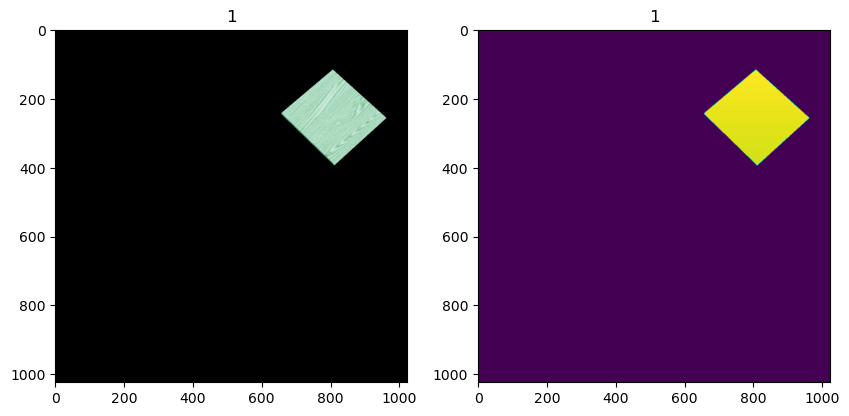

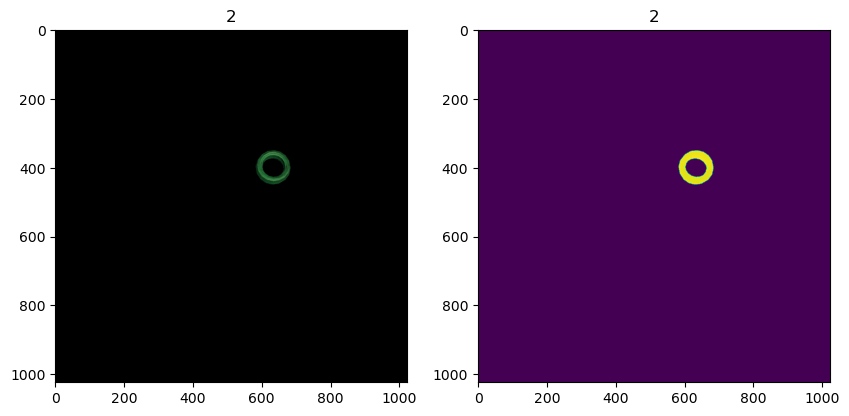

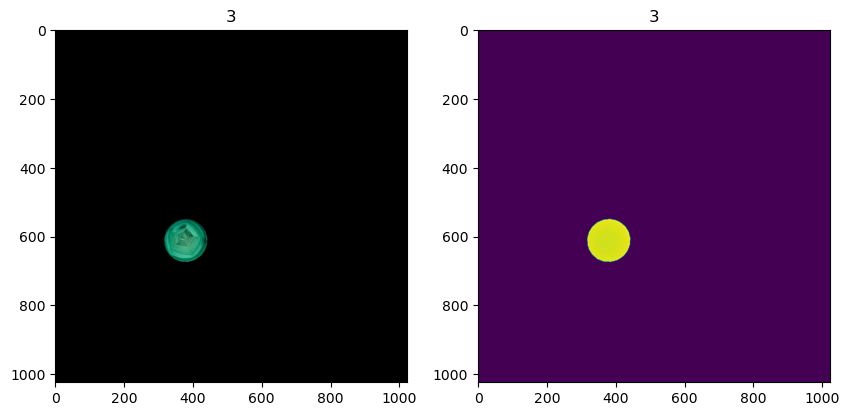

In [6]:
# loop over all seg masks
for o_id, color in zip(object_ids, object_segmentation_colors):
    area = get_mask_area(seg_arr[START_T], [color])
    image_masked = blackout_image(rgbds[START_T], area)
    depth_map_masked = image_masked[..., -1]
    rgb_masked = image_masked[..., 0:3]

    fig = plt.figure(figsize=[10, 5])
    ax = fig.add_subplot(121)
    ax.imshow(rgb_masked)
    ax.set_title(f"{o_id}")

    ax = fig.add_subplot(122)
    ax.imshow(depth_map_masked)
    ax.set_title(f"{o_id}")

In [7]:
all_meshes = {}
for path, dirs, files in os.walk(mesh_file_path):
    for name in (files + dirs):
        if name.endswith('.obj'):
            mesh = trimesh.load(os.path.join(path, name))
            all_meshes[name[:-4]] = mesh
ordered_all_meshes = collections.OrderedDict(sorted(all_meshes.items()))
len(ordered_all_meshes)

13

In [8]:
R = camera_matrix[:3,:3]
T = camera_matrix[0:3, 3]
a = np.array([-R[0,:], -R[1,:], -R[2,:]])
b = np.array(T)
camera_position_from_matrix = np.linalg.solve(a, b)
camera_rotation_from_matrix = -np.transpose(R)
camera_pose = b3d.Pose(
    camera_position_from_matrix,
    b3d.Rot.from_matrix(camera_rotation_from_matrix).as_quat()
)

In [9]:
# Defines the enumeration schedule.
scaling_factor = im_height/height
renderer = b3d.renderer.renderer_original.RendererOriginal(
    width * scaling_factor,
    height * scaling_factor,
    fx * scaling_factor,
    fy * scaling_factor,
    (width/2) * scaling_factor,
    (height/2) * scaling_factor,
    near_plane,
    far_plane,
)

b3d.reload(b3d.chisight.dense.dense_model)
b3d.reload(b3d.chisight.dense.likelihoods.laplace_likelihood)
likelihood_func = b3d.chisight.dense.likelihoods.laplace_likelihood.likelihood_func
model, viz_trace, info_from_trace = (
    b3d.chisight.dense.dense_model.make_dense_multiobject_model(
        renderer, likelihood_func
    )
)
importance_jit = jax.jit(model.importance)

likelihood_args = {
    "fx": renderer.fx,
    "fy": renderer.fy,
    "cx": renderer.cx,
    "cy": renderer.cy,
    "image_width": Pytree.const(renderer.width),
    "image_height": Pytree.const(renderer.height),
    "masked": Pytree.const(True),
    "check_interp": Pytree.const(False),
    "num_mc_sample": Pytree.const(500),
    "interp_penalty": Pytree.const(100),
}

/home/haoliangwang/b3d/.pixi/envs/gpu/lib/python3.12/site-packages/torch/utils/cpp_extension.py:1969: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [11]:
num_pose_grid = 11
position_search_thr = 0.1

# Gridding on translation only.
translation_deltas = b3d.Pose.concatenate_poses(
    [
        jax.vmap(lambda p: b3d.Pose.from_translation(p))(
            jnp.stack(
                jnp.meshgrid(
                    jnp.linspace(-position_search_thr, position_search_thr, num_pose_grid),
                    jnp.linspace(-position_search_thr, position_search_thr, num_pose_grid),
                    jnp.linspace(-position_search_thr, position_search_thr, num_pose_grid),
                ),
                axis=-1,
            ).reshape(-1, 3)
        ),
        b3d.Pose.identity()[None, ...],
    ]
)
# Sample orientations from a VMF to define a "grid" over orientations.
rotation_deltas = b3d.Pose.concatenate_poses(
    [
        jax.vmap(b3d.Pose.sample_gaussian_vmf_pose, in_axes=(0, None, None, None))(
            jax.random.split(jax.random.PRNGKey(0), num_pose_grid * num_pose_grid * num_pose_grid),
            b3d.Pose.identity(),
            0.001,
            10.0,
        ),
        b3d.Pose.identity()[None, ...],
    ]
)
all_deltas = b3d.Pose.stack_poses([translation_deltas, rotation_deltas])

# needs to be odd
num_scale_grid = 11
scale_search_thr = 0.2

scale_deltas = jnp.stack(
                jnp.meshgrid(
                    jnp.linspace(-scale_search_thr, scale_search_thr, num_scale_grid),
                    jnp.linspace(-scale_search_thr, scale_search_thr, num_scale_grid),
                    jnp.linspace(-scale_search_thr, scale_search_thr, num_scale_grid),
                ),
                axis=-1,
            ).reshape(-1, 3)

In [12]:
rgbds = jax.image.resize(rgbds, (rgbds.shape[0], im_height, im_width, *rgbds.shape[3:]), method="linear")
im_segs = jax.image.resize(seg_arr, (seg_arr.shape[0], im_height, im_width, *seg_arr.shape[3:]), method="linear")

2024-12-04 15:06:14.070913: W external/tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.94GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


XlaRuntimeError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 4227858432 bytes.

In [ ]:
num_inference_step = 5
im_seg = im_segs[START_T]
for i, (o_id, color) in enumerate(zip(object_ids, object_segmentation_colors)):
    if color not in np.unique(im_seg.reshape(-1, im_seg.shape[2]), axis=0):
        continue
    area = get_mask_area(im_seg, [color])
    image_masked = blackout_image(rgbds[START_T], area)

    point_cloud = np.asarray(unproject_pixels(area, image_masked[..., -1], camera_matrix, fx, fy))
    point_cloud_centroid = point_cloud.mean(0)
    point_cloud_bottom = min(point_cloud[:,1])
    object_pose = b3d.Pose.from_translation(np.array([point_cloud_centroid[0], point_cloud_bottom, point_cloud_centroid[2]]))
    print("gt pose: ", object_pose)
    point_cloud_size = np.array((max(point_cloud[:,0])-min(point_cloud[:,0]), max(point_cloud[:,1])-min(point_cloud[:,1]), max(point_cloud[:,2])-min(point_cloud[:,2])))
    object_colors = np.asarray(image_masked[..., 0:3][area])
    mean_object_colors = np.mean(object_colors, axis=0)

    if complicated:
        pass
    else:
        name = model_names[i]
        trim = ordered_all_meshes[name]
        bounding_box = trim.bounding_box
        bbox_corners = bounding_box.vertices
        original_size = np.array((max(bbox_corners[:,0])-min(bbox_corners[:,0]), max(bbox_corners[:,1])-min(bbox_corners[:,1]), max(bbox_corners[:,2])-min(bbox_corners[:,2])))
        object_scale = np.abs(point_cloud_size/original_size)
        # print("trim: ", trim.vertices)
        mesh = b3d.Mesh(scale_mesh(trim.vertices, object_scale), trim.faces, np.ones(trim.vertices.shape)*mean_object_colors)
        choice_map = dict([("camera_pose", camera_pose),
                            ("rgbd", image_masked),
                            ("depth_noise_variance", 0.01),
                            ("color_noise_variance", 1),
                            ("outlier_probability", 0.1),
                            ("object_pose_0", object_pose),
                            ("object_scale_0_0", jnp.array([1.0,1.0,1.0])),])

        trace, _ = importance_jit(
            jax.random.PRNGKey(0),
            genjax.ChoiceMap.d(
                choice_map
            ),
            (Pytree.const(("0",)), [mesh], likelihood_args),
        )

        for j, seed in enumerate(range(num_inference_step)):
            key = jax.random.PRNGKey(seed)
            trace, key, _, _ = bayes3d.enumerate_and_select_best_move_pose(
                trace, Pytree.const(("object_pose_0",)), key, all_deltas
            )
            trace, key, posterior_scales, scores = bayes3d.enumerate_and_select_best_move_scale(
                trace, Pytree.const(("object_scale_0_0",)), key, scale_deltas
            )
            viz_trace(trace, i*len(object_ids)+j, cloud=True)